In [40]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [20]:
# ============================================================
# 2. LOAD DATASET
# ============================================================

df = pd.read_csv("/content/IMDB Dataset.csv")

print("Sample data:")
print(df.head())

print("\nClass distribution:")
print(df["sentiment"].value_counts())


Sample data:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


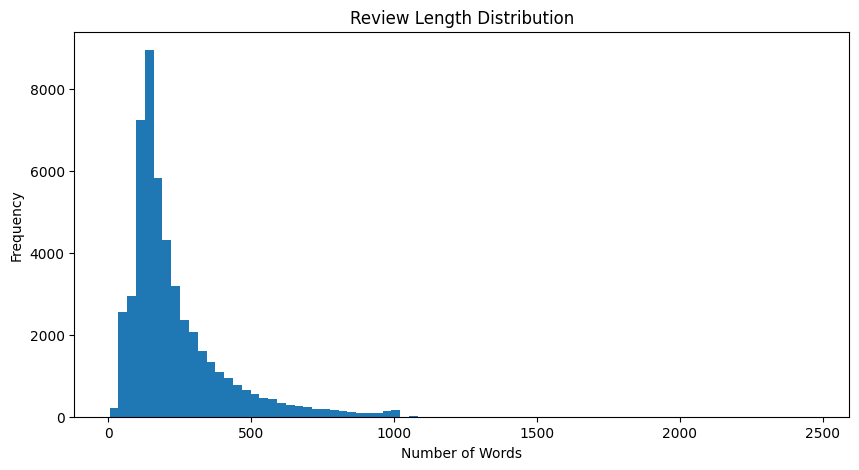

In [23]:
# ============================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================

df["review_length"] = df["review"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
plt.hist(df["review_length"], bins=80)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [24]:
print("\nExample Positive Review:")
print(df[df["sentiment"] == "positive"].iloc[0]["review"])

print("\nExample Negative Review:")
print(df[df["sentiment"] == "negative"].iloc[0]["review"])


Example Positive Review:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of 

In [25]:
# ============================================================
# 4. TEXT CLEANING & PREPROCESSING
# ============================================================

def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)         # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)     # Keep only letters
    text = text.lower()                        # Lowercase
    return text

df["clean_review"] = df["review"].apply(clean_text)

# Convert labels to numeric
df["label"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)

In [26]:
# ============================================================
# 5. TRAIN-TEST SPLIT
# ============================================================

X = df["clean_review"].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 40000
Testing samples: 10000


In [27]:
# ============================================================
# 6. TOKENIZATION & PADDING
# ============================================================

max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(train_seq, maxlen=max_len)
X_test_pad = pad_sequences(test_seq, maxlen=max_len)

In [30]:
# ============================================================
# 7. BUILD LSTM MODEL (FIXED VERSION)
# ============================================================

model = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=128,
        input_shape=(max_len,)
    ),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(1e-3),
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,419,905 (5.42 MB)

 Trainable params: 1,419,905 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# ============================================================
# 8. TRAIN MODEL
# ============================================================

history = model.fit(
    X_train_pad, y_train,
    epochs=4,
    batch_size=64,
    validation_split=0.2
)

# ============================================================
# 9. MODEL EVALUATION
# ============================================================

pred = (model.predict(X_test_pad) > 0.5).astype("int32")

print("\nClassification Report:")
print(classification_report(y_test, pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred))

Epoch 1/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 248s 491ms/step - accuracy: 0.6860 - loss: 0.5411 - val_accuracy: 0.8742 - val_loss: 0.3069
Epoch 2/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 243s 486ms/step - accuracy: 0.8932 - loss: 0.2698 - val_accuracy: 0.8425 - val_loss: 0.3577
Epoch 3/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 239s 479ms/step - accuracy: 0.9305 - loss: 0.1906 - val_accuracy: 0.8734 - val_loss: 0.3706
Epoch 4/4
500/500 ━━━━━━━━━━━━━━━━━━━━ 242s 483ms/step - accuracy: 0.9508 - loss: 0.1370 - val_accuracy: 0.8729 - val_loss: 0.3789
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5000
           1       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Confusion Matrix:
[[4339  661]
 [ 554 4446]]


<Figure size 600x500 with 0 Axes>

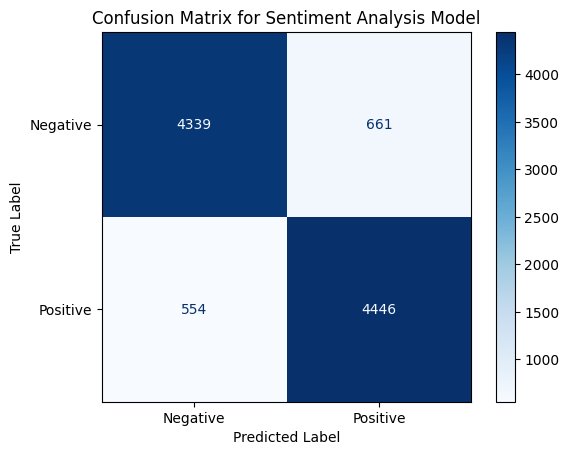

In [41]:
# Generate confusion matrix
cm = confusion_matrix(y_test, pred)

# Visual display
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues", colorbar=True)
plt.title("Confusion Matrix for Sentiment Analysis Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [38]:
# ============================================================
# 10. INFERENCE FUNCTION (PREDICT SINGLE REVIEW)
# ============================================================

def predict_sentiment(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len)
    prob = model.predict(pad)[0][0]
    return "Positive" if prob > 0.5 else "Negative"

print("\nSample Predictions:")
print(predict_sentiment("This movie is amazing!"))
print(predict_sentiment("Terrible and boring. I hated it."))


Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Negative
